Step 1: Data Cleaning and Saving Cleaned Versions

In [1]:
import pandas as pd
import numpy as np

creditcard_df = pd.read_csv('../data/creditcard.csv')
fraud_data_df = pd.read_csv('../data/Fraud_Data.csv')

In [2]:
creditcard_df.drop_duplicates(inplace=True)

In [3]:
creditcard_df['Time'] = pd.to_datetime(creditcard_df['Time'], unit='s', origin='2010-01-01')

In [4]:
creditcard_df.to_csv('../data/cleaned_creditcard.csv', index=False)

In [5]:
fraud_data_df.drop_duplicates(inplace=True)

In [6]:
fraud_data_df['signup_time'] = pd.to_datetime(fraud_data_df['signup_time'])
fraud_data_df['purchase_time'] = pd.to_datetime(fraud_data_df['purchase_time'])

In [7]:
fraud_data_df.to_csv('../data/cleaned_fraud_data.csv', index=False)

In [8]:
fraud_data_df['signup_time'] = pd.to_datetime(fraud_data_df['signup_time'])
fraud_data_df['purchase_time'] = pd.to_datetime(fraud_data_df['purchase_time'])
fraud_data_df['signup_month'] = fraud_data_df['signup_time'].dt.month
fraud_data_df['signup_day'] = fraud_data_df['signup_time'].dt.day
fraud_data_df['purchase_month'] = fraud_data_df['purchase_time'].dt.month
fraud_data_df['purchase_day'] = fraud_data_df['purchase_time'].dt.day
fraud_data_df['purchase_hour'] = fraud_data_df['purchase_time'].dt.hour
fraud_data_df['time_diff'] = (fraud_data_df['purchase_time'] - fraud_data_df['signup_time']).dt.total_seconds() / 3600

In [9]:
fraud_data_df.drop(['signup_time', 'purchase_time'], axis=1, inplace=True)

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

fraud_data_df['device_id_encoded'] = le.fit_transform(fraud_data_df['device_id'])

fraud_data_df = fraud_data_df.drop(['device_id'], axis=1)

In [11]:
creditcard_df['Time'] = pd.to_datetime(creditcard_df['Time'], unit='s', origin='unix')
creditcard_df['transaction_hour'] = creditcard_df['Time'].dt.hour
creditcard_df['transaction_day'] = creditcard_df['Time'].dt.day
creditcard_df['transaction_month'] = creditcard_df['Time'].dt.month

In [12]:
creditcard_df.drop(['Time'], axis=1, inplace=True)

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
fraud_data_df['source'] = label_encoder.fit_transform(fraud_data_df['source'])
fraud_data_df['browser'] = label_encoder.fit_transform(fraud_data_df['browser'])
fraud_data_df['sex'] = label_encoder.fit_transform(fraud_data_df['sex'])

In [14]:
scaler = StandardScaler()

numerical_columns_fraud = fraud_data_df.select_dtypes(include=['int64', 'float64']).columns.difference(['class'])
fraud_data_df[numerical_columns_fraud] = scaler.fit_transform(fraud_data_df[numerical_columns_fraud])

In [15]:
numerical_columns_credit = creditcard_df.select_dtypes(include=['int64', 'float64']).columns.difference(['Class'])
creditcard_df[numerical_columns_credit] = scaler.fit_transform(creditcard_df[numerical_columns_credit])

Feature and Target Separation

In [16]:
X_fraud = fraud_data_df.drop('class', axis=1)
y_fraud = fraud_data_df['class']

X_credit = creditcard_df.drop('Class', axis=1)
y_credit = creditcard_df['Class']

Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)


In [18]:
X_train_fraud.to_csv('../data/X_train_fraud.csv', index=False)
X_test_fraud.to_csv('../data/X_test_fraud.csv', index=False)
y_train_fraud.to_csv('../data/y_train_fraud.csv', index=False)
y_test_fraud.to_csv('../data/y_test_fraud.csv', index=False)

X_train_credit.to_csv('../data/X_train_credit.csv', index=False)
X_test_credit.to_csv('../data/X_test_credit.csv', index=False)
y_train_credit.to_csv('../data/y_train_credit.csv', index=False)
y_test_credit.to_csv('../data/y_test_credit.csv', index=False)

print("Preprocessing complete! Data is ready for training.")

Preprocessing complete! Data is ready for training.


Step 2: Model Selection

In [19]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical

def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else float('nan')
        
        mlflow.log_params(model.get_params())
        mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        })
        
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"{model_name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC-AUC: {roc_auc}")

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
}

In [21]:
print("\nTraining models on credit card data...")
for model_name, model in models.items():
    train_and_evaluate_model(model, model_name + " - Credit", X_train_credit, X_test_credit, y_train_credit, y_test_credit)


Training models on credit card data...


2024/10/26 18:22:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - Credit - Accuracy: 0.9992246149508336, Precision: 0.896551724137931, Recall: 0.5777777777777777, F1 Score: 0.7027027027027027, ROC-AUC: 0.9652120791364649


2024/10/26 18:22:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree - Credit - Accuracy: 0.9991012582384662, Precision: 0.7052631578947368, Recall: 0.7444444444444445, F1 Score: 0.7243243243243244, ROC-AUC: 0.8719751168847469


2024/10/26 18:26:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Credit - Accuracy: 0.9995594403129736, Precision: 0.9850746268656716, Recall: 0.7333333333333333, F1 Score: 0.8407643312101911, ROC-AUC: 0.9145920604662839


2024/10/26 18:32:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting - Credit - Accuracy: 0.9992951045007578, Precision: 0.890625, Recall: 0.6333333333333333, F1 Score: 0.7402597402597403, ROC-AUC: 0.7664991841601556


2024/10/26 18:34:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLP Classifier - Credit - Accuracy: 0.999365594050682, Precision: 0.921875, Recall: 0.6555555555555556, F1 Score: 0.7662337662337663, ROC-AUC: 0.9482269211459413


In [22]:
print("Training models on fraud data...")
for model_name, model in models.items():
    train_and_evaluate_model(model, model_name + " - Fraud", X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud)

Training models on fraud data...


c:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/10/26 18:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - Fraud - Accuracy: 0.9331303973794792, Precision: 0.958011049723757, Recall: 0.3042105263157895, F1 Score: 0.4617842876165113, ROC-AUC: 0.7649434165181338


2024/10/26 18:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree - Fraud - Accuracy: 0.901697382787943, Precision: 0.48190248279988035, Recall: 0.5652631578947368, F1 Score: 0.5202648151138382, ROC-AUC: 0.750994564370961


2024/10/26 18:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Fraud - Accuracy: 0.9564239155609966, Precision: 1.0, Recall: 0.5378947368421053, F1 Score: 0.6995208761122519, ROC-AUC: 0.7749984970463276


2024/10/26 18:35:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting - Fraud - Accuracy: 0.9564570029447772, Precision: 1.0, Recall: 0.5382456140350877, F1 Score: 0.6998175182481752, ROC-AUC: 0.7761667438973352


2024/10/26 18:40:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLP Classifier - Fraud - Accuracy: 0.9082155973927142, Precision: 0.975, Recall: 0.02736842105263158, F1 Score: 0.05324232081911263, ROC-AUC: 0.7601018675721563


# ---------------------------
# Deep Learning Models (CNN, RNN, LSTM)
# ---------------------------

In [23]:
from keras.callbacks import EarlyStopping

def build_and_train_keras_model(model, model_name, X_train, X_test, y_train, y_test, input_shape):
    with mlflow.start_run(run_name=model_name):
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        
        model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping])
        loss, accuracy = model.evaluate(X_test, y_test)
        
        
        y_proba = model.predict(X_test).ravel()
        y_pred = (y_proba > 0.5).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        
        mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        })
        mlflow.keras.log_model(model, model_name)
        
        print(f"{model_name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC-AUC: {roc_auc}")

In [24]:
X_train_fraud_dl = np.expand_dims(X_train_fraud.values, axis=2)
X_test_fraud_dl = np.expand_dims(X_test_fraud.values, axis=2)
X_train_credit_dl = np.expand_dims(X_train_credit.values, axis=2)
X_test_credit_dl = np.expand_dims(X_test_credit.values, axis=2)

In [25]:
cnn_model = Sequential([
    Conv1D(32, 2, activation='relu', input_shape=(X_train_fraud_dl.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
build_and_train_keras_model(cnn_model, "CNN - Fraud", X_train_fraud_dl, X_test_fraud_dl, y_train_fraud, y_test_fraud, X_train_fraud_dl.shape[1])

c:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8455 - loss: 64.4966 - val_accuracy: 0.9092 - val_loss: 10.4308
Epoch 2/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8679 - loss: 8.7983 - val_accuracy: 0.9098 - val_loss: 8.4477
Epoch 3/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8766 - loss: 5.0033 - val_accuracy: 0.9076 - val_loss: 14.1165
Epoch 4/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8759 - loss: 3.8696 - val_accuracy: 0.8461 - val_loss: 0.9588
Epoch 5/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8810 - loss: 2.3708 - val_accuracy: 0.9364 - val_loss: 0.5950
Epoch 6/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8906 - loss: 1.6823 - val_accuracy: 0.8934 - val_loss: 0.4139
Epoch 7/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9067 - loss: 0.8383 - val_accuracy: 0.9443 - val_loss: 0.4387
Epoch 8/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9190 - loss: 0.530

2024/10/26 18:42:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/26 18:43:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CNN - Fraud - Accuracy: 0.9552989602088928, Precision: 0.9758730158730159, Recall: 0.539298245614035, F1 Score: 0.6946892655367232, ROC-AUC: 0.7701207682560802


In [26]:
lstm_model = Sequential([
    LSTM(32, input_shape=(X_train_fraud_dl.shape[1], 1)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
build_and_train_keras_model(lstm_model, "LSTM - Fraud", X_train_fraud_dl, X_test_fraud_dl, y_train_fraud, y_test_fraud, X_train_fraud_dl.shape[1])

c:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9318 - loss: 0.2326 - val_accuracy: 0.9544 - val_loss: 0.1861
Epoch 2/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9539 - loss: 0.1859 - val_accuracy: 0.9550 - val_loss: 0.1833
Epoch 3/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9560 - loss: 0.1801 - val_accuracy: 0.9551 - val_loss: 0.1817
Epoch 4/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9554 - loss: 0.1815 - val_accuracy: 0.9557 - val_loss: 0.1810
Epoch 5/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9563 - loss: 0.1787 - val_accuracy: 0.9549 - val_loss: 0.1890
Epoch 6/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9564 - loss: 0.1783 - val_accuracy: 0.9554 - val_loss: 0.1825
Epoch 7/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9562 - loss: 0.1783 - val_accuracy: 0.9557 - val_loss: 0.1827
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9561 - loss: 0.1810
945/945 

2024/10/26 18:45:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/26 18:45:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LSTM - Fraud - Accuracy: 0.9559937715530396, Precision: 0.9896907216494846, Recall: 0.5389473684210526, F1 Score: 0.6978646069968196, ROC-AUC: 0.7702159254124791


In [27]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model
input_shape_cnn = (X_train_credit_dl.shape[1], X_train_credit_dl.shape[2])
cnn_model = create_cnn_model(input_shape_cnn)

build_and_train_keras_model(cnn_model, "CNN - Credit", X_train_credit_dl, X_test_credit_dl, y_train_credit, y_test_credit, input_shape_cnn)


Epoch 1/20


c:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5675/5675 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9989 - loss: 0.0098 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 2/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0038
Epoch 3/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9991 - val_loss: 0.0049
Epoch 4/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 5/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9993 - val_loss: 0.0035
Epoch 6/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9993 - val_loss: 0.0038
Epoch 7/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9993 - val_loss: 0.0040
Epoch 8/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9994 - loss: 0.0029 - val

2024/10/26 18:48:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/26 18:48:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CNN - Credit - Accuracy: 0.9995594620704651, Precision: 0.9710144927536232, Recall: 0.7444444444444445, F1 Score: 0.8427672955974843, ROC-AUC: 0.9526355941510558


In [28]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_shape_lstm = (X_train_credit_dl.shape[1], X_train_credit_dl.shape[2])
lstm_model = create_lstm_model(input_shape_lstm)

build_and_train_keras_model(lstm_model, "LSTM - Credit", X_train_credit_dl, X_test_credit_dl, y_train_credit, y_test_credit, input_shape_lstm)


c:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - accuracy: 0.9983 - loss: 14.7100 - val_accuracy: 0.9981 - val_loss: 0.0117
Epoch 2/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - accuracy: 0.9984 - loss: 0.0125 - val_accuracy: 0.9981 - val_loss: 0.0077
Epoch 3/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - accuracy: 0.9984 - loss: 0.0501 - val_accuracy: 0.9983 - val_loss: 0.0071
Epoch 4/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9985 - val_loss: 0.0050
Epoch 5/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 71s 12ms/step - accuracy: 0.9989 - loss: 0.0055 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 6/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - accuracy: 0.9992 - loss: 0.0044 - val_accuracy: 0.9992 - val_loss: 0.0043
Epoch 7/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - accuracy: 0.9988 - loss: 97.4539 - val_accuracy: 0.9985 - val_loss: 0.0072
Epoch 8/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - accuracy: 0.9985

2024/10/26 18:59:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/26 18:59:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LSTM - Credit - Accuracy: 0.9984844923019409, Precision: 0.75, Recall: 0.06666666666666667, F1 Score: 0.12244897959183673, ROC-AUC: 0.8821164376039412


In [29]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(100, activation='relu', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_shape_rnn = (X_train_credit_dl.shape[1], X_train_credit_dl.shape[2])
rnn_model = create_rnn_model(input_shape_rnn)

build_and_train_keras_model(rnn_model, "RNN - Credit", X_train_credit_dl, X_test_credit_dl, y_train_credit, y_test_credit, input_shape_rnn)


c:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9983 - loss: 0.0180 - val_accuracy: 0.9986 - val_loss: 0.0067
Epoch 2/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9988 - loss: 0.0081 - val_accuracy: 0.9962 - val_loss: 0.0136
Epoch 3/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.9990 - val_loss: 0.0050
Epoch 4/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9991 - loss: 0.0057 - val_accuracy: 0.9983 - val_loss: 0.0072
Epoch 5/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9988 - loss: 0.0082 - val_accuracy: 0.9985 - val_loss: 0.0095
Epoch 6/20
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 0.9990 - val_loss: 0.0063
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9993 - loss: 0.0054
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2024/10/26 19:02:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/26 19:02:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RNN - Credit - Accuracy: 0.9991717338562012, Precision: 0.9056603773584906, Recall: 0.5333333333333333, F1 Score: 0.6713286713286714, ROC-AUC: 0.8517909253506541


In [30]:
build_and_train_keras_model(rnn_model, "RNN - Fraud", X_train_fraud_dl, X_test_fraud_dl, y_train_fraud, y_test_fraud, input_shape_rnn)

Epoch 1/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8549 - loss: 128.0201 - val_accuracy: 0.9155 - val_loss: 43.4783
Epoch 2/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8956 - loss: 29.1584 - val_accuracy: 0.9335 - val_loss: 38.9487
Epoch 3/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9113 - loss: 30.3504 - val_accuracy: 0.9497 - val_loss: 26.8358
Epoch 4/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9125 - loss: 31.5828 - val_accuracy: 0.9507 - val_loss: 5.9510
Epoch 5/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9108 - loss: 32.6909 - val_accuracy: 0.9547 - val_loss: 22.7607
Epoch 6/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9129 - loss: 29.6688 - val_accuracy: 0.9538 - val_loss: 24.5178
Epoch 7/20
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9137 - loss: 30.3896 - val_accuracy: 0.9535 - val_loss: 14.1955
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9530 - loss: 1

2024/10/26 19:03:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/26 19:03:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RNN - Fraud - Accuracy: 0.9535784125328064, Precision: 0.9441375076734193, Recall: 0.5396491228070175, F1 Score: 0.686760437597678, ROC-AUC: 0.7680152359124531


Task-3: Model Explainability 

c:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


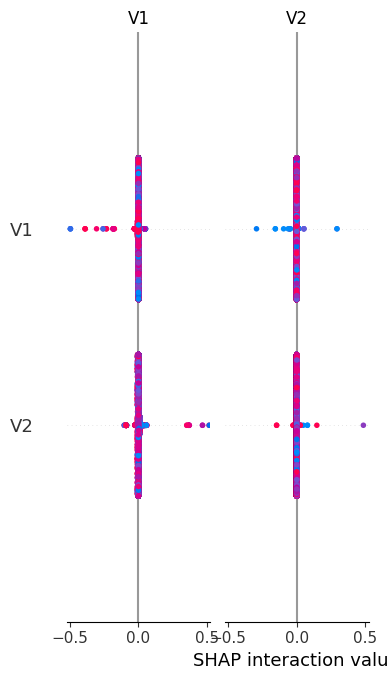

In [31]:
import shap
import pandas as pd
import pickle

with open(r'C:\Users\USER\Documents\OPLearning\10_Academy\Week_8_&_9\mlruns\262221609415836645\71d97f3edb874d09a1a8f3bbd4d3da2a\artifacts\Decision Tree - Credit\model.pkl', 'rb') as f:
    model = pickle.load(f)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_credit)

shap.summary_plot(shap_values, X_train_credit)
